<a href="https://colab.research.google.com/github/Ogu1208/Steam-data-analysis-classification-model-training-time-series-prediction/blob/main/Steam_%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84_%EB%B6%84%EC%84%9D_%2B_%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1_%ED%9A%8C%EA%B7%80_%2B_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 로지스틱 회귀

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")


In [ ]:
data = pd.read_csv('AllData.csv')  # 다양한 특징, 'mean' 열에 평균 플레이어 수 포함 게임의 정제된 데이터
data = data[data['mean'] > 1]  # 'mean' 열의 값이 1보다 큰 게임들만 선택

data.shape


(8093, 81)

In [ ]:
# 분류에 필요하지 않은 열들을 제거 (이름, APP id 등)
proc_data = data.drop(['App_id','Name','ReleaseDate','Metacritic','SteamSpyOwners', 'SteamSpyOwnersVariance',
                      'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'PriceCurrency','SupportEmail',
                      'SupportURL', 'AboutText','Background', 'ShortDescrip', 'DetailedDescrip', 'DRMNotice',
                      'ExtUserAcctNotice', 'HeaderImage', 'LegalNotice', 'Reviews','RecommendationCount',
                      'SupportedLanguages', 'Website', 'PCMinReqsText', 'PCRecReqsText',
                      'LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText','MacRecReqsText',
                      'SteamSpyOwnersNew', 'peak_max', 'peak_mean', 'max'],axis=1)

##  두 클래스로 분류


In [ ]:
#"인기도"를 기준으로 평균 플레이어 수  "grade" 열 생성
def create_grades(count):
#평균 플레이어 수 >= 100 경우 1을 반환, <5인 경우 0 반환
        if 100<=count:
            return 1
        elif count<5:
            return 0
#평균 플레이어 수가 5보다 크고 100보다 작은 경우 중간 범주인 -1 반환
        else:
            return -1

proc_data['grade']=proc_data['mean'].apply(create_grades)

# 중간 범주에 속하는 게임들을 제외
data_for_classification=proc_data[(proc_data['grade']==0)|(proc_data['grade']==1)]

In [ ]:
# 모든 특징을 포함한 행렬
X=data_for_classification.drop(['mean','grade'],axis=1).copy()
X=X.astype(float)

# 종속 변수: 인기도 등급
y=data_for_classification['grade'].copy()

## 상관관계 히트맵


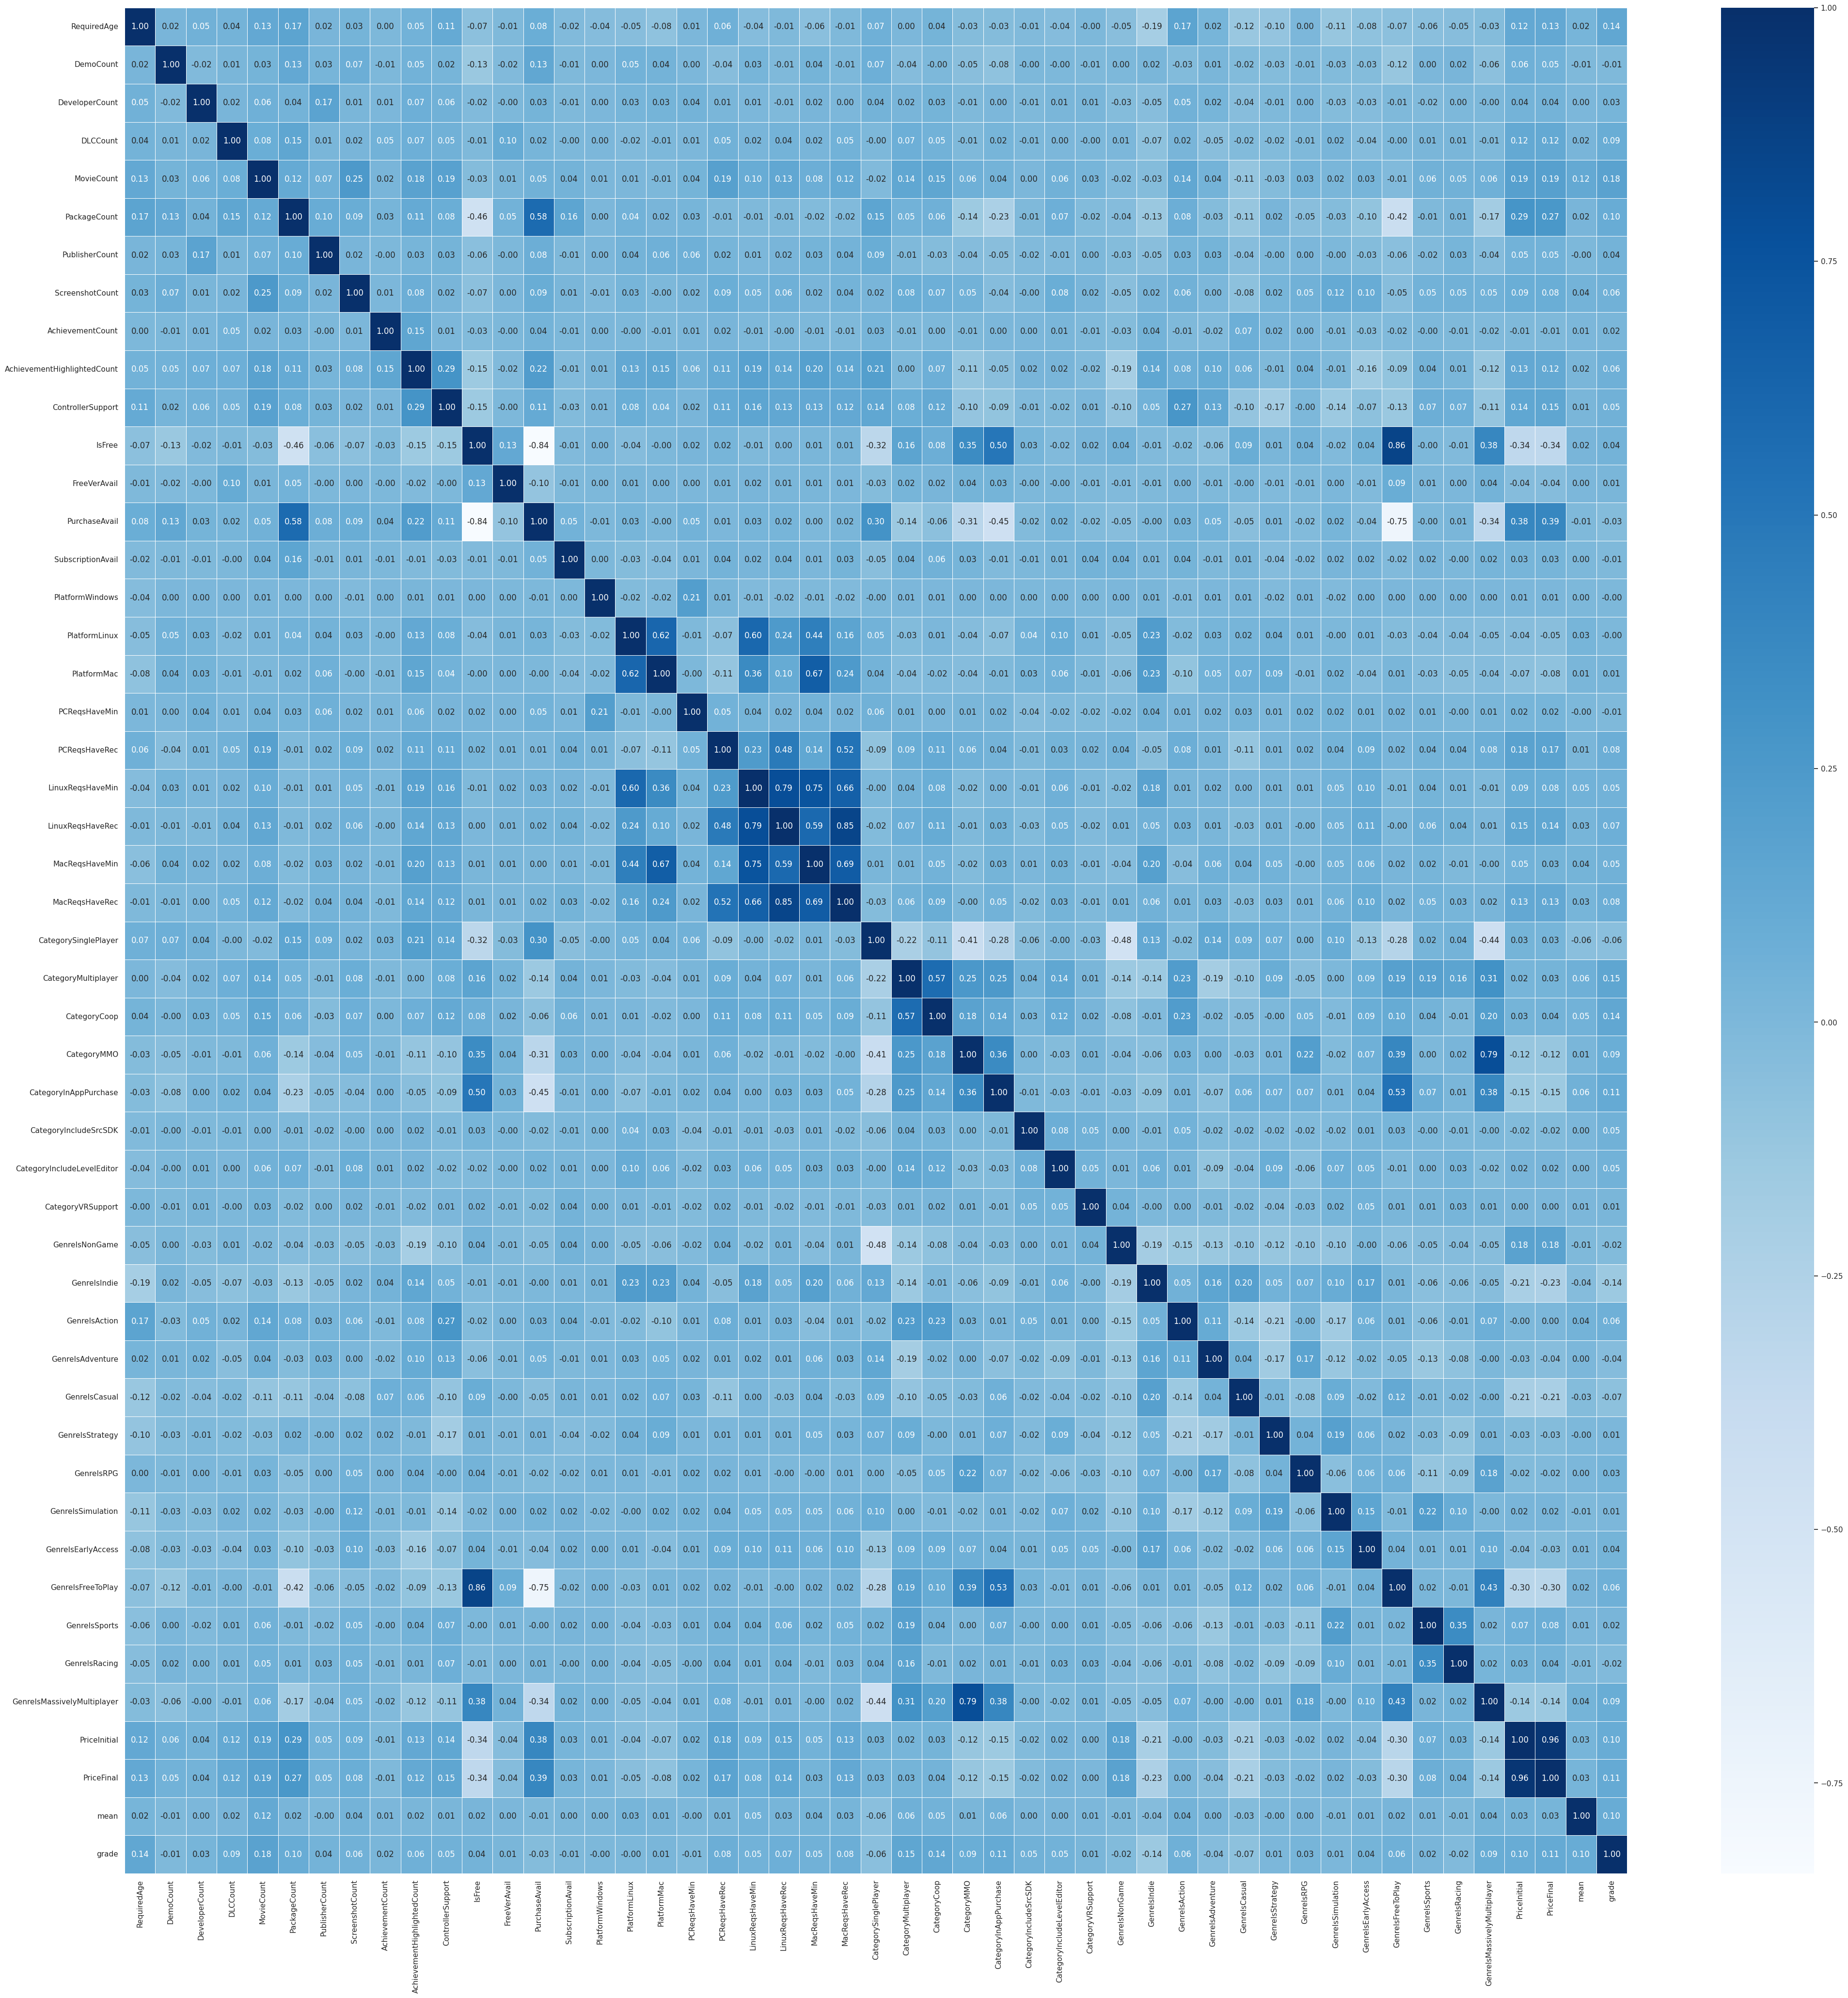

In [ ]:
df = proc_data.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(50,50) )


# 히트맵을 그린다
sns.heatmap(df,
            annot = True,   # 실제 값을 표시한다
            fmt = '.2f', linewidths=.5,
            cmap='Blues'
           )
plt.show()

## Model


In [ ]:
#모델링 - 로지스틱
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone

# 성능 평가 관련 라이브러리
from sklearn.metrics import accuracy_score  #정확도 (전체 샘플중 맞게 예측한 샘플수)
from sklearn.metrics import precision_score # 정밀도 (양성이라고 판단한 샘플중 실제 양성 클래스인것)
from sklearn.metrics import recall_score #재현율(실제 양성중에 양성으로 예측된 비율 )
from sklearn.metrics import f1_score # 정밀도와 재현율의 조화 평균입니다

#경고 무시
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [ ]:
# 설계 행렬과 종속 변수에 대한 훈련 및 테스트 분할을 생성
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,    # 75-25 분할
                                                    random_state=42,   # 재현성을 위한 난수 시드
                                                    shuffle=True,      # 분할 전에 데이터를 섞음
                                                    stratify=y)        # 목표 변수에 대해 계층적 분할하여 클래스 불균형을 방지


### 로지스틱 모델 : 클래스 확률 예측
로지스틱 모델의 파라미터 : c -> 규제의 강도를 조절 (기본값 : 1, 작게 설정할수록 규제가 강해짐)


In [ ]:
# LogisticRegression 모델 학습에서 하이퍼파라미터 C를 최적화하기 위한 k-폴드(k=5) 교차 검증을 시행

# kfold 객체 생성 (5개의 부분집함으로 나눔)
kfold = StratifiedKFold(5, shuffle=True, random_state=42)

# 탐색할 정규화 매개변수 범위 정의
cvalues = np.logspace(-5, 1, 100)

# 정확도, 정밀도, 재현율, F1 점수를 저장할 배열 생성 (5개의 집합으로 나눔)
accs = np.zeros((5, len(cvalues)))
prec = np.zeros((5, len(cvalues)))
recs = np.zeros((5, len(cvalues)))
f1s = np.zeros((5, len(cvalues)))

# 훈련 테스트 분할을 추적하기 위한 변수
i = 0

for train_index, test_index in kfold.split(X_train, y_train):
    # 교차 검증 훈련 테스트 분할 가져오기
    X_train_train, X_train_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]

    for j in range(len(cvalues)):
        # 모델 객체 생성
        log_reg_clone = clone(LogisticRegression(class_weight='balanced', penalty='l2', C=cvalues[j]))

        # 모델 훈련
        log_reg_clone.fit(X_train_train, y_train_train)

        # 예측
        y_pred = log_reg_clone.predict(X_train_test)

        # 정확도, 정밀도, 재현율, F1 측정
        accs[i, j] = accuracy_score(y_train_test, y_pred)
        prec[i, j] = precision_score(y_train_test, y_pred)
        recs[i, j] = recall_score(y_train_test, y_pred)
        f1s[i, j] = f1_score(y_train_test, y_pred)

    i = i + 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

## 결과

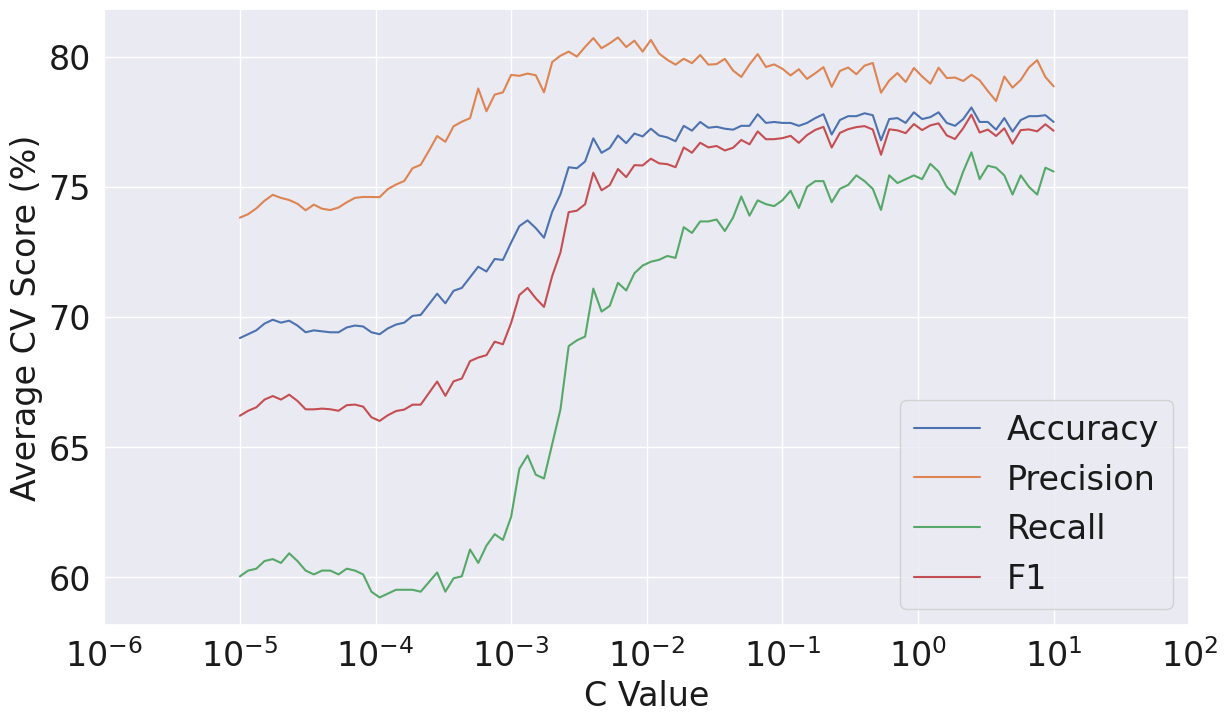

In [ ]:
# 데이터 시각화
plt.figure(figsize=(14,8))
fontsize=24
fontcolor='k'

plt.plot(cvalues, 100*np.mean(accs, axis=0),label='Accuracy')
plt.plot(cvalues, 100*np.mean(prec, axis=0),label='Precision')
plt.plot(cvalues, 100*np.mean(recs, axis=0),label='Recall')
plt.plot(cvalues, 100*np.mean(f1s, axis=0),label='F1')

plt.xlabel("C Value", fontsize=fontsize,color=fontcolor)
plt.ylabel("Average CV Score (%)", fontsize=fontsize,color=fontcolor) # 교차 검증 성능

plt.setp(plt.legend(fontsize=fontsize).get_texts(), color=fontcolor)
plt.xticks(fontsize=fontsize,color=fontcolor)
plt.xscale('log')
plt.xlim(cvalues[0]*0.1,cvalues[-1]*10)
plt.yticks(fontsize=fontsize,color=fontcolor)
plt.show()

In [ ]:
# # 가장 적절한 C 값은 각 지표별로 다음과 같이 나타남
print("평균 CV 정확도가 가장 높은 c 값",
         cvalues[np.argmax(np.mean(accs, axis=0))])
print("평균 CV 정밀도가 가장 높은 c 값",
         cvalues[np.argmax(np.mean(prec, axis=0))])
print("평균 CV 재현율이 가장 높은 c 값",
         cvalues[np.argmax(np.mean(recs, axis=0))])
print("평균 CV F1 점수가 가장 높은 c 값",
         cvalues[np.argmax(np.mean(f1s, axis=0))])


평균 CV 정확도가 가장 높은 c 값 2.4770763559917137
평균 CV 정밀도가 가장 높은 c 값 0.006135907273413176
평균 CV 재현율이 가장 높은 c 값 2.4770763559917137
평균 CV F1 점수가 가장 높은 c 값 2.4770763559917137


In [ ]:
# C=0.53으로 검증된 모델을 전체 학습 데이터에 대해 훈련하고 테스트 성능 계산 및 평가
log_reg = LogisticRegression(class_weight='balanced', C=0.5, penalty='l2')

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print('테스트 세트 정확도: ', np.round(100 * accuracy_score(y_test, y_pred), 2))
print('테스트 세트 정밀도: ', np.round(100 * precision_score(y_test, y_pred), 2))
print('테스트 세트 재현율: ', np.round(100 * recall_score(y_test, y_pred), 2))
print('테스트 세트 F1-점수: ', np.round(100 * f1_score(y_test, y_pred), 2))


테스트 세트 정확도:  78.78
테스트 세트 정밀도:  79.91
테스트 세트 재현율:  77.26
테스트 세트 F1-점수:  78.56


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 모델이 학습하여 갖고 있는 상관계수(독립변수와 종속변수 간의 관계를 수치화한 것)를 시각화
 coefficient는 각 독립변수에 해당하는 상관계수를 의미하며
- Coefficient (로지스틱 회귀계수, 추정된 파라미터 값)
 양수이면 종속변수와 양의 상관관계, 음수이면 종속변수와 음의 상관관계
 시각화 결과 : AchievementCount 변수를 기준으로 위로 갈수록 양의 상관관계를 갖고, 아래로 내려갈수록 음의 상관관계를 크게 갖는다.

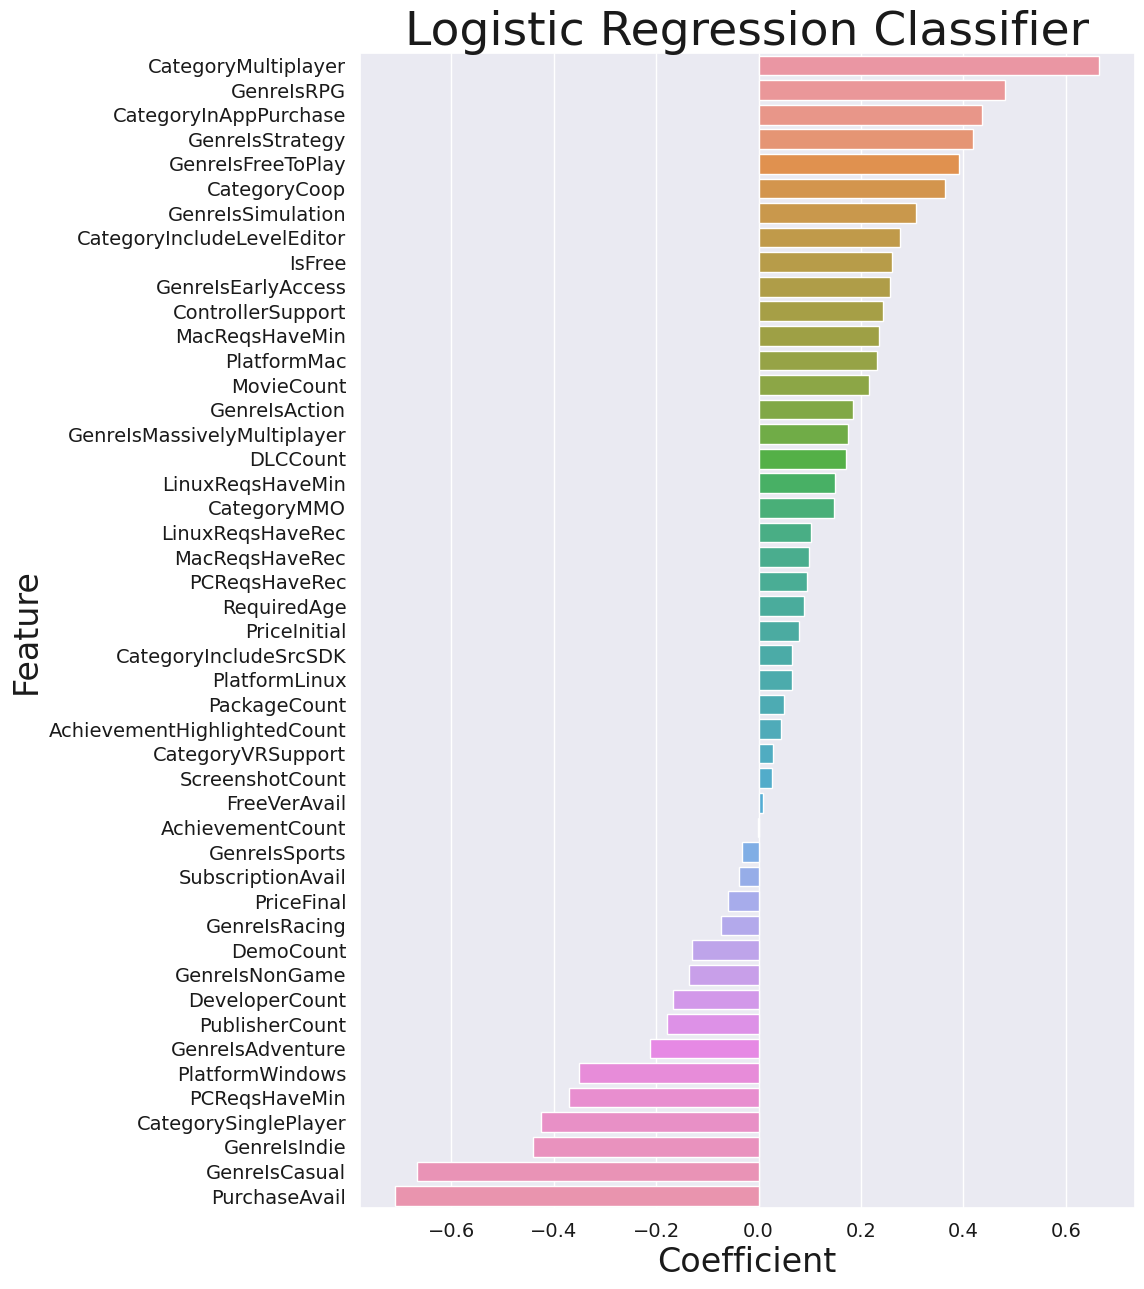

In [ ]:
#In this case, we can also detect coefficients and guage feature importance
names = []
scores = []
for name, score in zip(X_test.columns,log_reg.coef_[0]):
    names.append(name)
    scores.append(np.round(score,4))

score_df = pd.DataFrame({'feature':names,'coefficients':scores})
score_df.sort_values('coefficients',ascending=False)

f,ax = plt.subplots(figsize=(10,15))

plt.title('Logistic Regression Classifier',fontsize=fontsize+10,color=fontcolor)
sns.barplot(x="coefficients", y="feature", data=score_df.sort_values('coefficients',ascending=False))

plt.xlabel("Coefficient",fontsize=fontsize,color=fontcolor)
plt.ylabel("Feature",fontsize=fontsize,color=fontcolor)

plt.xticks(fontsize=fontsize-10,color=fontcolor)
plt.yticks(fontsize=fontsize-10,color=fontcolor)
plt.show()

# 랜덤 포레스트

## Model

In [ ]:
# 모델링 - 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone

# 성능 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# 경고 무시
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [ ]:
# 설계 행렬과 종속 변수에 대한 훈련 및 테스트 분할을 생성
# 위의 로지스틱 모델링 코드와 동일
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,    # 75-25 분할 비율
                                                    random_state=42,   # 재현성을 위한 랜덤 시드
                                                    shuffle=True,      # 분할 전에 데이터를 섞음
                                                    stratify=y)        # 목표 변수를 기준으로 계층화하여 클래스 불균형을 방지


In [ ]:
#  RandomForestClassifier 분류에서 하이퍼파라미터 max_depth를 최적화하기 위해 5-fold 계층화 교차 검증 시행

# kfold 객체 생성
kfold = StratifiedKFold(5, shuffle=True, random_state=42)

# 검색할 최대 깊이 정의
n = 50

# accuracy_score, precision_score, recall_score 및 f1_score를 위한 배열 생성
accs = np.zeros((5, n))
prec = np.zeros((5, n))
recs = np.zeros((5, n))
f1s = np.zeros((5, n))

for j in range(1, n + 1):
    # 10번의 반복마다 max_depth를 출력
    if j % 10 == 0:
        print(j)

    # 모델 객체 생성
    rf = RandomForestClassifier(n_estimators=500, max_depth=j, random_state=42)

    # 훈련 세트와 테스트 세트를 추적하기 위한 변수
    i = 0
    for train_index, test_index in kfold.split(X_train, y_train):
        # 교차 검증 훈련 및 테스트 세트 얻기
        X_train_train, X_train_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # 모델 피팅
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train, y_train_train)

        # 예측
        y_predict = rf_clone.predict(X_train_test)

        # 정확도, 정밀도, 재현율, F1 측정
        accs[i, j - 1] = accuracy_score(y_train_test, y_predict)
        prec[i, j - 1] = precision_score(y_train_test, y_predict)
        recs[i, j - 1] = recall_score(y_train_test, y_predict)
        f1s[i, j - 1] = f1_score(y_train_test, y_predict)

        i = i + 1


10
20
30
40
50


## 결과

max_depth의 값은 15 ~ 20 중에 사이의 값으로 선정하여 모델링을 진행하는 것이 적합하다고 판단됨

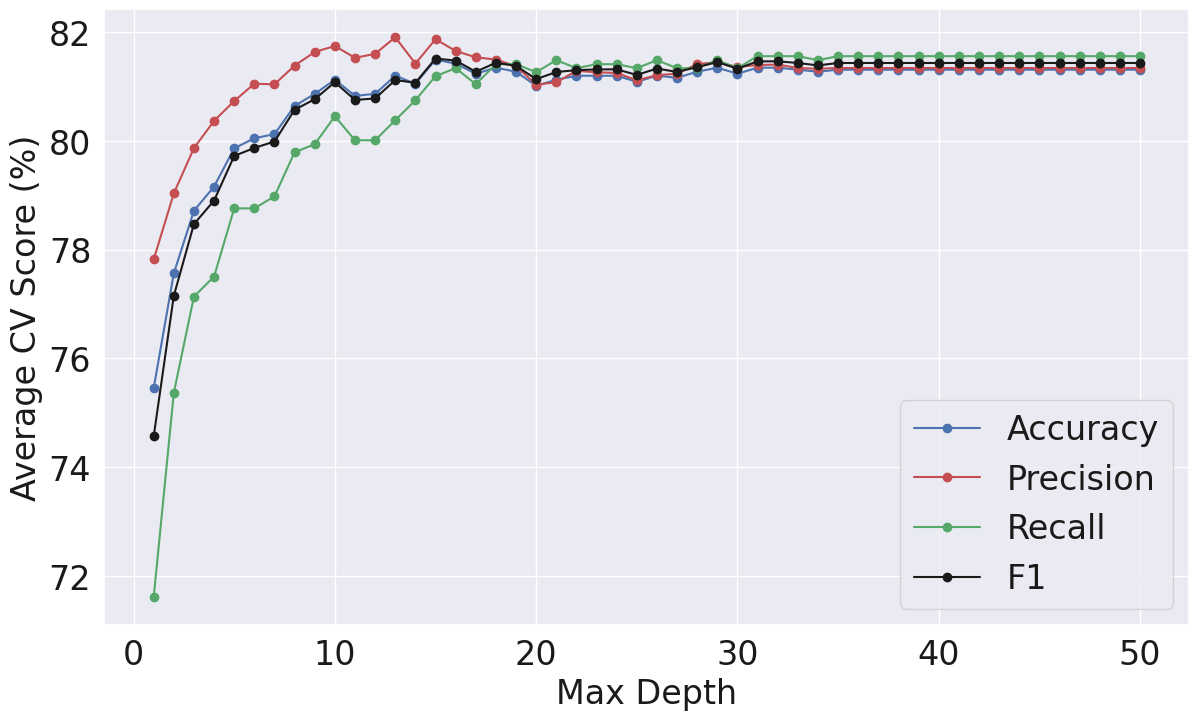

In [ ]:
# 결과 시각화
plt.figure(figsize=(14,8))
fontsize=24
fontcolor='k'

plt.plot(range(1,n+1), 100*np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), 100*np.mean(prec,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), 100*np.mean(recs,axis=0),'g-o', label="Recall")
plt.plot(range(1,n+1), 100*np.mean(f1s,axis=0),'k-o', label="F1")

plt.xlabel("Max Depth", fontsize=fontsize,color=fontcolor) # max_depth : 트리의 최대 깊이 -> 값을 증가할수록 모델일 복잡해지지만 과적합하면 예측이 어려움
plt.ylabel("Average CV Score (%)", fontsize=fontsize,color=fontcolor)

plt.setp(plt.legend(fontsize=fontsize).get_texts(), color=fontcolor)
plt.xticks(fontsize=fontsize,color=fontcolor)
plt.yticks(fontsize=fontsize,color=fontcolor)
plt.show()

In [ ]:
# 가장 적절한 max_depth 값은 각 지표별로 다음과 같이 나타남
# 최고 정확도:
rf_best_acc, rf_best_acc_index = (np.max(100*np.mean(accs, axis=0)), np.argmax(100*np.mean(accs, axis=0)))
print('최대 정확도:', np.round(rf_best_acc, 2), 'max_depth:', rf_best_acc_index + 1)
print()

# 최고 정밀도:
rf_best_prec, rf_best_prec_index = (np.max(100*np.mean(prec, axis=0)), np.argmax(100*np.mean(prec, axis=0)))
print('최대 정밀도:', np.round(rf_best_prec, 2), 'max_depth:', rf_best_prec_index + 1)
print()

# 최고 재현율:
rf_best_rec, rf_best_rec_index = (np.max(100*np.mean(recs, axis=0)), np.argmax(100*np.mean(recs, axis=0)))
print('최대 재현율:', np.round(rf_best_rec, 2), 'max_depth:', rf_best_rec_index + 1)
print()

# 최고 F1 스코어:
rf_best_f1, rf_best_f1_index = (np.max(100*np.mean(f1s, axis=0)), np.argmax(100*np.mean(f1s, axis=0)))
print('최대 F1 스코어:', np.round(rf_best_f1, 2), 'max_depth:', rf_best_f1_index + 1)
print()


최대 정확도: 81.5 max_depth: 15

최대 정밀도: 81.91 max_depth: 13

최대 재현율: 81.56 max_depth: 31

최대 F1 스코어: 81.52 max_depth: 15



In [ ]:
# 이제 max_depth를 15로 변경하여 모델을 훈련하고 테스트 세트에서의 성능을 계산
rf = RandomForestClassifier(n_estimators=500, max_depth=15, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('테스트 정확도:', np.round(100*accuracy_score(y_test, y_pred), 2))
print('테스트 정밀도:', np.round(100*precision_score(y_test, y_pred), 2))
print('테스트 재현율:', np.round(100*recall_score(y_test, y_pred), 2))
print('테스트 F1 스코어:', np.round(100*f1_score(y_test, y_pred), 2))


테스트 정확도: 82.67
테스트 정밀도: 83.67
테스트 재현율: 81.46
테스트 F1 스코어: 82.55


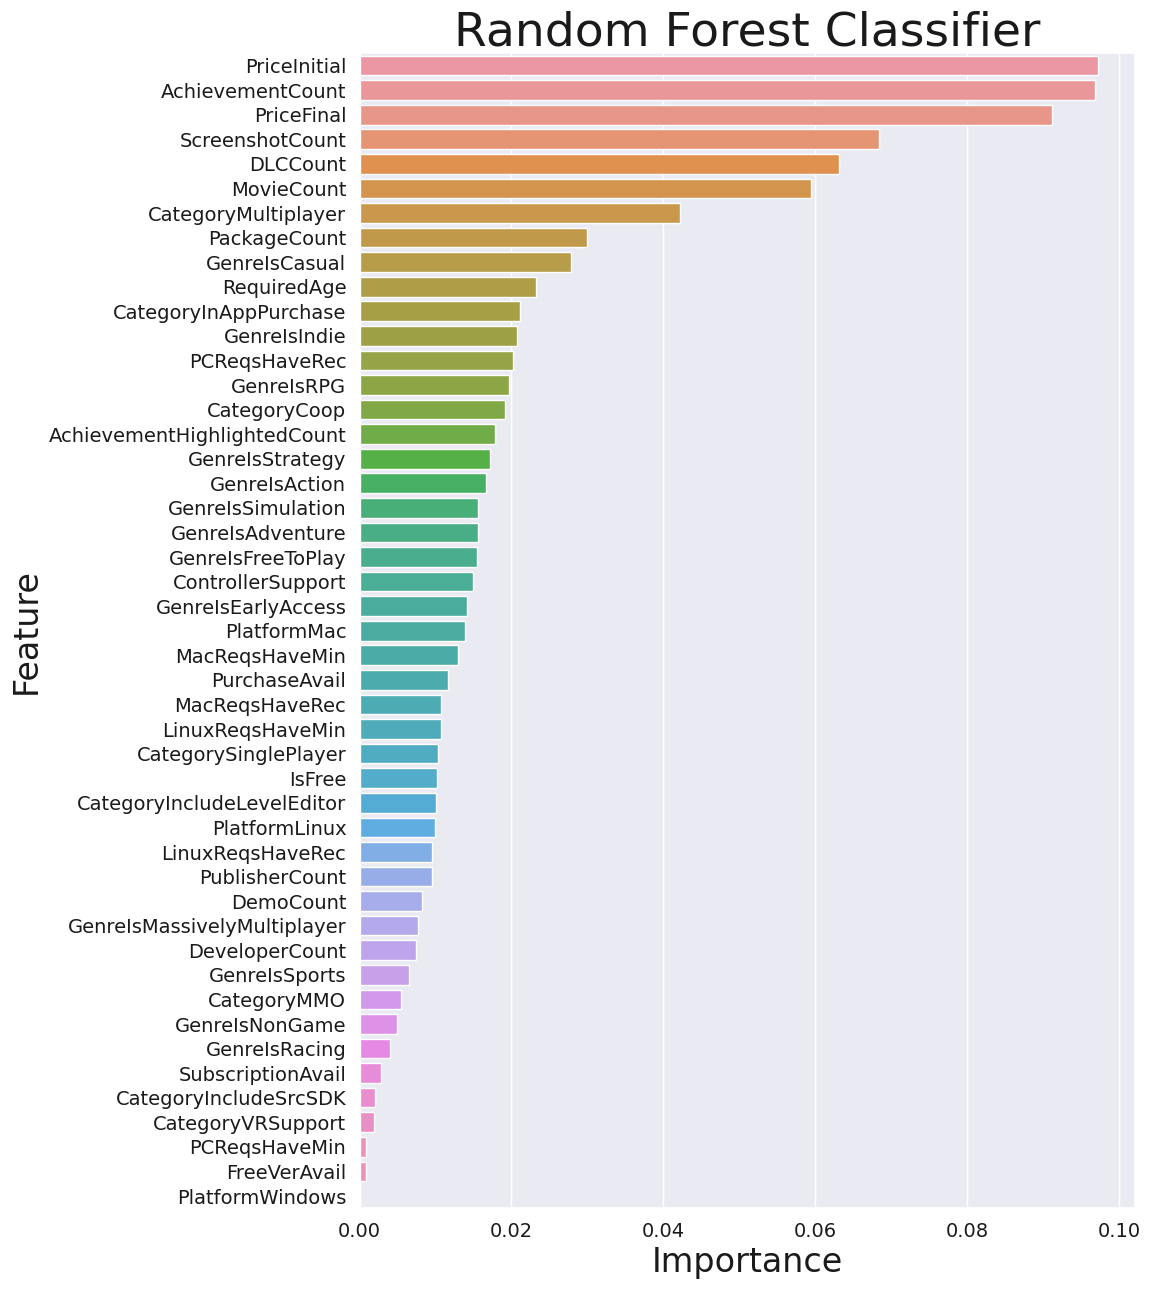

In [ ]:
# 랜덤 포레스트 모델은 로지스틱 모델과 다르게 모델 자체에서 변수별 중요도 파라미터가 있음
# 변수별 중요도란, 어떤 변수가 종속변수를 예측하게 될 때 가장 잘 예측할 수 있게 해주는 관계를 갖고 있는지에 대한 것을 수치화한 것
# 따라서, 중요도 점수가 크면 클수록 종속변수를 예측하는데 있어서 중요한 변수임
# 시각화 결과 : 아래에서 위로 갈수록, 종속변수를 예측하는 것에 있어서 가장 중요한 변수
names = []
scores = []
for name, score in zip(X_test.columns,rf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))

score_df = pd.DataFrame({'feature':names,'importance':scores})

f,ax = plt.subplots(figsize=(10,15))

plt.title('Random Forest Classifier',fontsize=fontsize+10,color=fontcolor)
sns.barplot(x="importance", y="feature", data=score_df.sort_values('importance',ascending=False))

plt.xlabel("Importance",fontsize=fontsize,color=fontcolor)
plt.ylabel("Feature",fontsize=fontsize,color=fontcolor)

plt.xticks(fontsize=fontsize-10,color=fontcolor)
plt.yticks(fontsize=fontsize-10,color=fontcolor)
plt.show()